In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score

We already know what features to select from the EDA performed, and the correlation matrix displayed.

In [2]:
df = pd.read_csv('dataset/cleaned_pets.csv')

In [3]:
df = df.filter(['AdoptionSpeed','Age','AgeBins','Description'])

In [4]:
df.shape

(14947, 4)

## Evaluation Protocol and Measurements of Success

For this dataset, we will need the precision for each of the 5 adoption speed classes, and the overall accuracy of the model.

The dataset is slightly below 15k samples. A small dataset, for this, K-fold cross validation

## Feature Engineering

Creating a new feature based of the 3 colors, into a singular multi-color combination label. If animals has more than 1 color coat, it has multi color, else 0.

Same thing for Vaccinated and Sterilized. New feature immunized.

Another feautre to create is description length, do short description influence adoption speed.

We also know from the EDA that majority breeds are mixed or domestic, with many pure breeds having a very low counts. Group them into 'Others'.

 Log Transformation of Age, Quantity and WordCount to normalize the distribution has no effect on random forest or GB, but reduces others performance.

In [5]:
df['MultiColor'] = np.where((df['Color2'] == 0) & (df['Color3'] == 0),0,1)

In [6]:
df['Immunized'] = np.where((df['Vaccinated'] == 1) & (df['Sterilized'] == 1),1,0)

In [7]:
df = df.drop(columns={'Color1','Color2','Color3'})

In [5]:
df['WordCount'] = df['Description'].apply(lambda x: len(x.split()))

In [9]:
def breed_transform(row):
    if row['Breed1'] == 266:
        return 'Domestic Short Hair'
    elif row['Breed1'] == 264:
        return 'Domestic Long Hair'
    elif row['Breed1'] == 265:
        return 'Domestic Medium Hair'
    elif row['Breed1'] == 307:
        return 'Mixed Breed'
    else:
        return 'Others'

In [10]:
df['Breed1'] = df.apply(breed_transform, axis=1)

In [6]:
df['Pregnant'] = np.where(df['Description'].str.contains('pregnant') == True,1,0)

In [12]:
df.shape

(14947, 17)

In [7]:
df.head(3)

,AdoptionSpeed,Age,AgeBins,Description,WordCount,Pregnant
0,2,3,"[3,6]",nibble month old ball cuteness energetic playf...,34,0
1,0,1,"[0,2]",found alone yesterday near apartment shaking b...,11,0
2,3,1,"[0,2]",pregnant mother dumped irresponsible owner roa...,38,1


In [14]:
df.describe()

,AdoptionSpeed,Age,Gender,MaturitySize,Health,Quantity,Vaccinated,Sterilized,FurLength,Type,MultiColor,Immunized,WordCount,Pregnant
count,14947.000000,14947.000000,14947.000000,14947.000000,14947.000000,14947.000000,14947.000000,14947.000000,14947.000000,14947.000000,14947.000000,14947.000000,14947.000000,14947.000000
mean,2.516492,10.451663,1.776209,1.862247,1.036596,1.575835,1.731117,1.914030,1.467719,1.457550,0.701813,0.167525,40.726969,0.018131
std,1.177328,18.158534,0.681444,0.547329,0.199521,1.473228,0.667854,0.566147,0.599030,0.498211,0.457477,0.373457,46.574389,0.133429
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,14.000000,0.000000
50%,2.000000,3.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,28.000000,0.000000
75%,4.000000,11.500000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,51.000000,0.000000
max,4.000000,255.000000,3.000000,4.000000,3.000000,20.000000,3.000000,3.000000,3.000000,2.000000,1.000000,1.000000,1207.000000,1.000000


## Data Preparation

Split into train and test.

In [8]:
#features and labels

X = df.iloc[:,1:]

y = df['AdoptionSpeed']

In [16]:
X.head(2)

,Age,Breed1,Gender,MaturitySize,Health,Quantity,Description,Vaccinated,Sterilized,FurLength,Type,MultiColor,Immunized,WordCount,Pregnant
0,3,Others,1,1,1,1,nibble month old ball cuteness energetic playf...,2,2,1,2,1,0,34,0
1,1,Domestic Medium Hair,1,2,1,1,found alone yesterday near apartment shaking b...,3,3,2,2,1,0,11,0


In [21]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

##  Age and quantity outliers

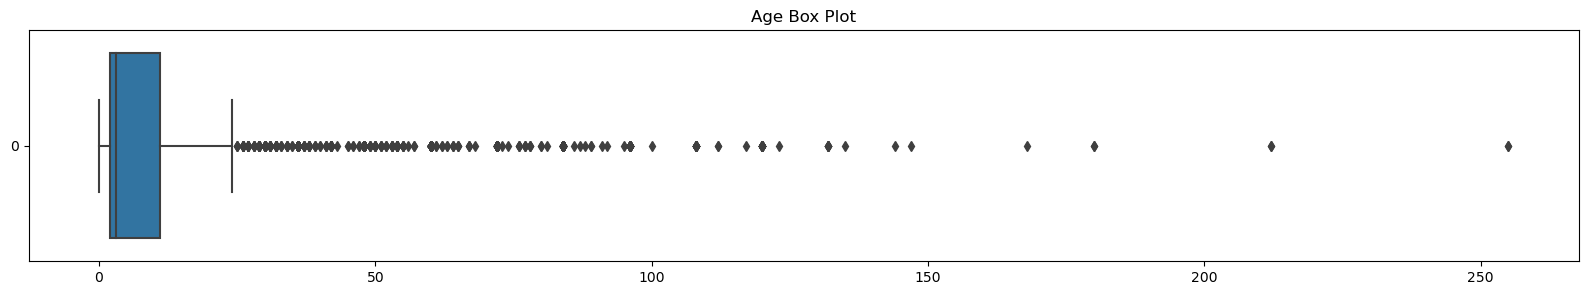

In [18]:
plt.figure(figsize=(20,3))
sns.boxplot(X_train['Age'],orient='h')
plt.title('Age Box Plot')
plt.show()

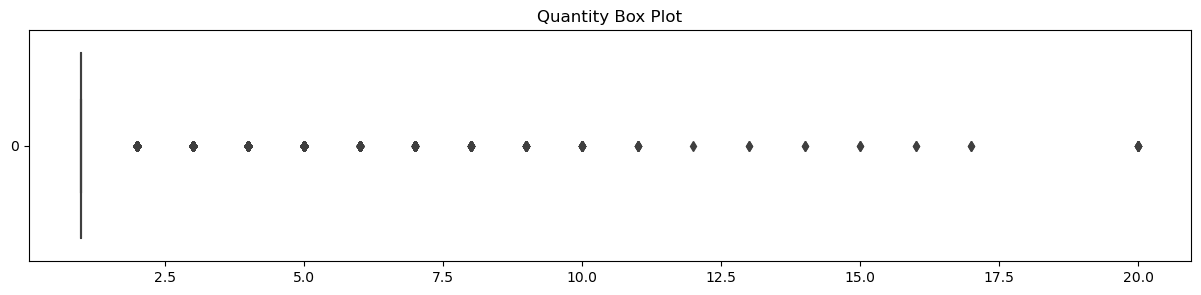

In [19]:
plt.figure(figsize=(15,3))
sns.boxplot(X_train['Quantity'],orient='h')
plt.title('Quantity Box Plot')
plt.show()

In [20]:
def removeOutliers(col,threshold,x,y):
    outlierIndexes = x.index[x[col]>threshold].tolist()
    x = x.drop(outlierIndexes)
    y = y.drop(outlierIndexes)
    
    plt.figure(figsize=(20,3))
    sns.boxplot(x[col],orient='h')
    plt.title(f'{col} box plot outliers dropped')
    plt.show()
    
    return x,y

# Removal of outliers actually decreased the performance by 1-3%.

In [21]:
print(X_train.shape)
print(y_train.shape)

(10462, 15)
(10462,)


Now to plot the counts of each of the multi-class labels.

In [22]:
y_counts = y_train.value_counts()

In [23]:
y_counts

AdoptionSpeed
4    2936
2    2794
3    2264
1    2177
0     291
Name: count, dtype: int64

In [24]:
adoptionSpeed_counts_X = y_counts.index.values.tolist()
adoptionSpeed_counts_Y = y_counts.to_list()

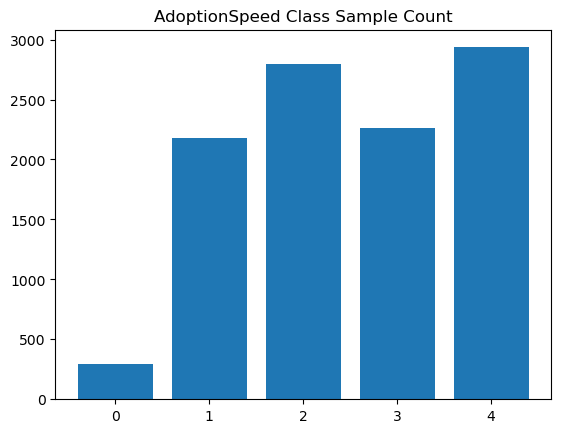

In [25]:
fig, ax = plt.subplots()

ax.bar(adoptionSpeed_counts_X, adoptionSpeed_counts_Y)
ax.set_title('AdoptionSpeed Class Sample Count')

plt.show()

The 0 class has a significantly lower sample count compared to the rest. Since the dataset is a reflection of real pet listings and adoption rates, I will not artifially balance the classes through data augmentation.

Standardize the age range, photo amount and quantity, then one hot encode all the other categorical features.

In [26]:
def plotDistribution(df):
    fig, ax = plt.subplots(2,1,figsize=(15, 10))
    
    ax[0].bar(df['Age'].unique(),df['Age'].value_counts())
    ax[0].set_title('Age Distribution')
    
    ax[1].bar(df['WordCount'].unique(),df['WordCount'].value_counts())
    ax[1].set_title('WordCount Distribution')
    
    
    plt.show()

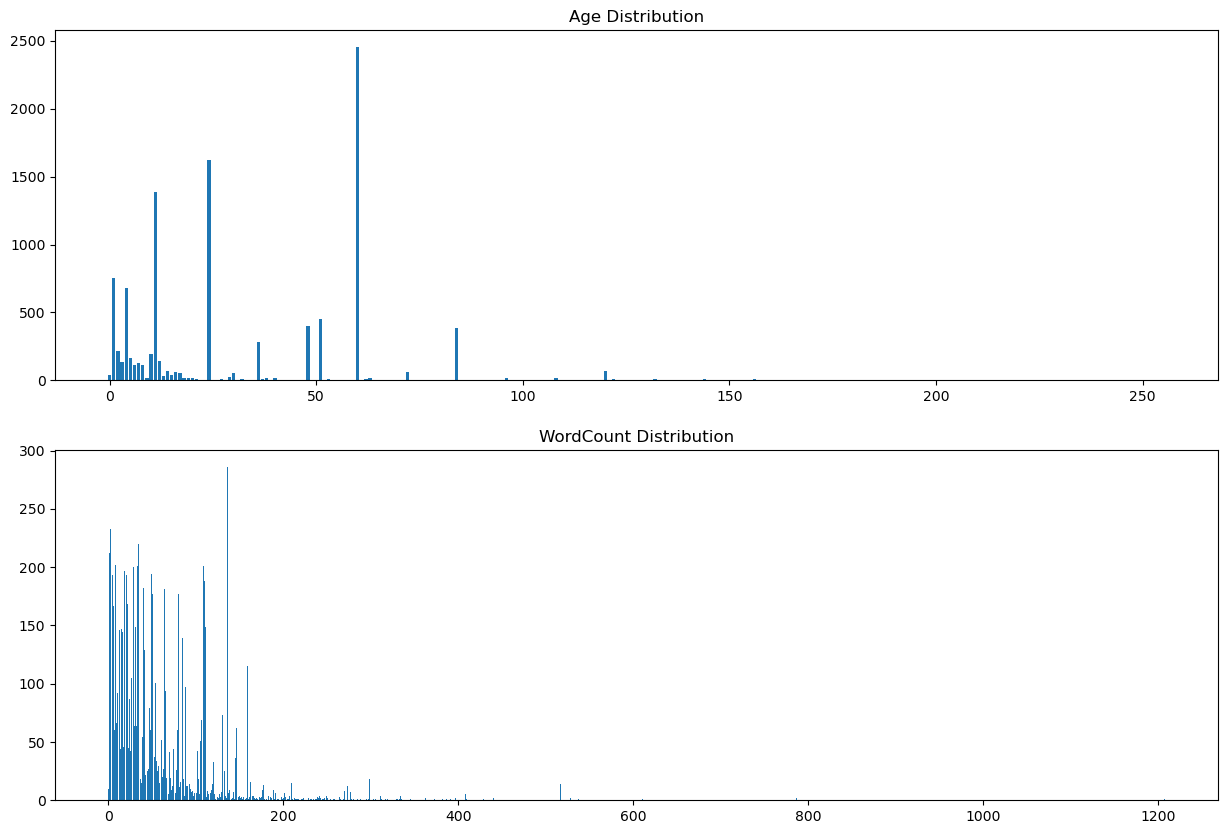

In [27]:
plotDistribution(X_train)

In [16]:
#takes pandas df and the col to tranforms, return the df
def log_transformation(df,col):
    df['temp'] = np.log1p(df[col])
    df = df.drop(columns=col)
    df = df.rename(columns={'temp':col})
    return df

In [29]:
X_train = log_transformation(X_train,'Age')
X_train = log_transformation(X_train,'WordCount')

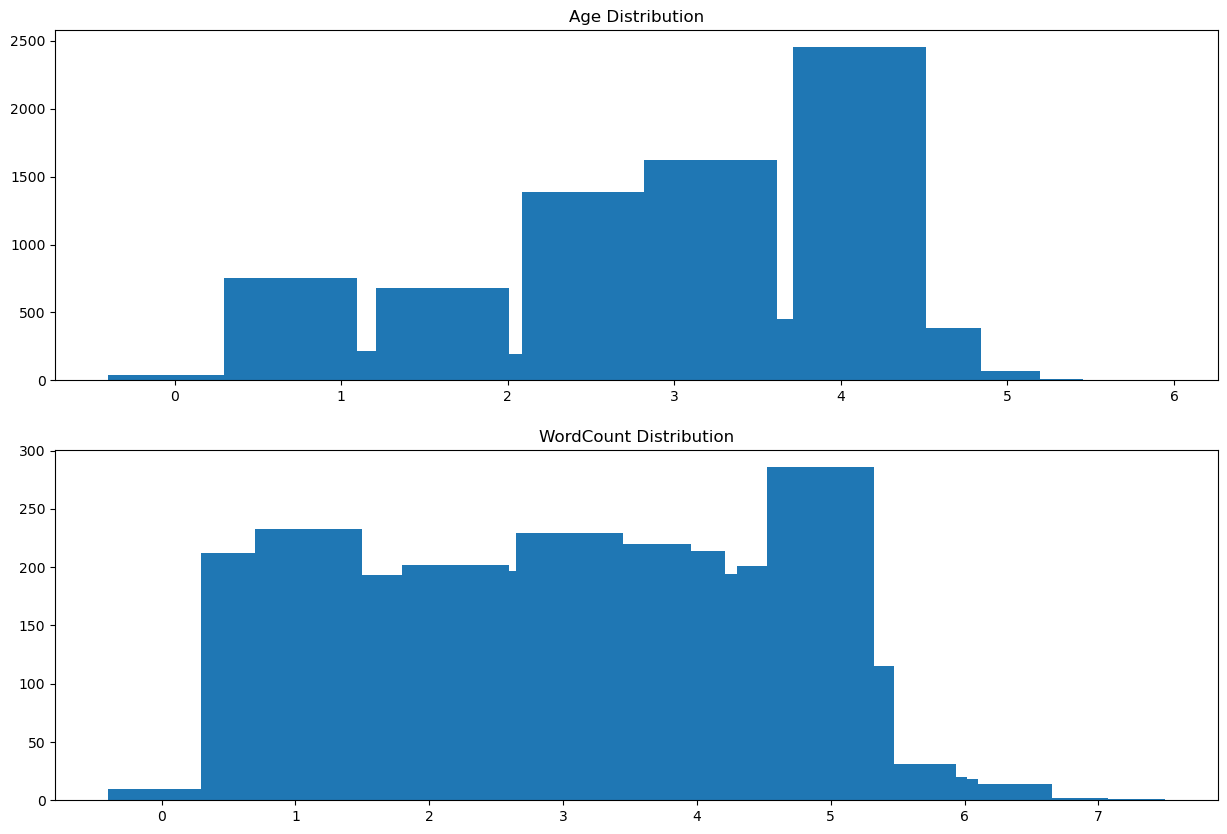

In [30]:
plotDistribution(X_train)

# Model Selection

Here we decide what model to use.

## Baseline Model

Importing and loading our classification models, then evaluating and establishing a baseline model to beat.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [18]:
transformer = ColumnTransformer(transformers=[
    ('a1', StandardScaler(), ['Age','WordCount','Quantity']),
    ('a2', OneHotEncoder(handle_unknown='ignore'), ['AgeBins','Breed1','Gender','MaturitySize','Health','Vaccinated',
                                                    'Sterilized','FurLength','Type','MultiColor',
                                                    'Immunized','Pregnant']),
    ('a3', CountVectorizer(), 'Description'),
], remainder='passthrough')

In [22]:
X_train = transformer.fit_transform(X_train)
X_test= transformer.transform(X_test)

In [23]:
def getBaseModel(x,y,x2,y2):
    models_list = [
    SVC(decision_function_shape='ovo'),
    LogisticRegression(multi_class='ovr',max_iter=1000),
    KNeighborsClassifier(n_neighbors=5),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier()]
    
    for model in models_list:
        model.fit(x,y)
        results = model.predict(x2)
        print(f'Results for {model}')
        print(classification_report(y2,results))

In [24]:
getBaseModel(X_train,y_train,X_test,y_test)

Results for SVC(decision_function_shape='ovo')
              precision    recall  f1-score   support

           0       1.00      0.01      0.02        84
           1       0.40      0.27      0.32       651
           2       0.39      0.68      0.50       814
           3       0.47      0.25      0.33       629
           4       0.95      0.94      0.94       812

    accuracy                           0.55      2990
   macro avg       0.64      0.43      0.42      2990
weighted avg       0.58      0.55      0.53      2990

Results for LogisticRegression(max_iter=1000, multi_class='ovr')
              precision    recall  f1-score   support

           0       0.29      0.06      0.10        84
           1       0.41      0.39      0.40       651
           2       0.42      0.50      0.46       814
           3       0.41      0.38      0.39       629
           4       0.97      0.97      0.97       812

    accuracy                           0.57      2990
   macro avg       

In [ ]:
from sklearn.model_selection import learning_curve

In [ ]:
train_sizes_abs,train_scores,test_scores = learning_curve(RandomForestClassifier(),
                                          X_train,
                                          y_train,
                                          cv=5,
                                          scoring='accuracy',
                                          n_jobs=-1,
                                          train_sizes=np.linspace(0.01,1,50),
                                          verbose=1)

In [ ]:
train_mean = np.mean(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)

In [ ]:
plt.plot(train_sizes_abs,train_mean, label='Training Score')
plt.plot(train_sizes_abs,test_mean, label='Validation Score')
plt.legend()
plt.title('Learning Curve')
plt.show()

# Pipeline

The pipeline includes selectkbest features, as the model is overfitting, and not capturing the pattern between classes 1, 2 and 3.

In [ ]:
X = log_transformation(X,'Age')
X = log_transformation(X,'WordCount')

In [12]:
pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(transformers=[
        ('a1', MinMaxScaler(), ['Age','WordCount']),
        ('a2', OneHotEncoder(handle_unknown='ignore'), ['Pregnant','AgeBins']),
        ('a3', CountVectorizer(), 'Description'),], remainder='passthrough')),
    ('model', RandomForestClassifier())
])

In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [14]:
scores = cross_val_score(pipeline, X, y, cv=kf)

In [15]:
def displayCrossValScores(score):
    x_labels = [x for x in range(1,6)]
    plt.bar(x_labels,scores)
    plt.title('Cross Val Scores')
    plt.plot() 
    print(np.mean(score))

0.5710837843553452


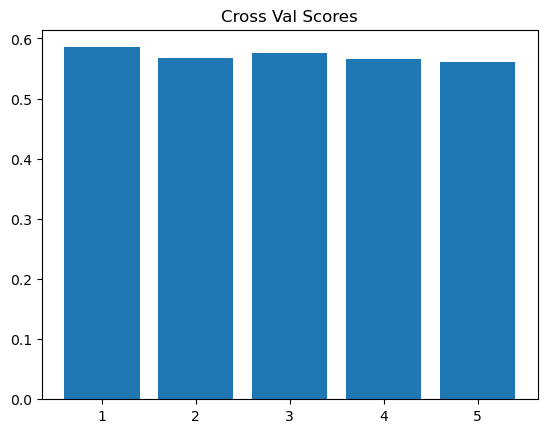

In [16]:
displayCrossValScores(scores)

In [23]:
baseline_clf = RandomForestClassifier()
baseline_clf.fit(X_train,y_train)
baseline_results = baseline_clf.predict(X_test)

In [24]:
print(classification_report(y_test,baseline_results))

              precision    recall  f1-score   support

           0       0.69      0.08      0.14       113
           1       0.47      0.35      0.40       943
           2       0.42      0.66      0.51      1194
           3       0.48      0.33      0.39       939
           4       0.98      0.97      0.97      1296

    accuracy                           0.60      4485
   macro avg       0.61      0.48      0.48      4485
weighted avg       0.61      0.60      0.59      4485



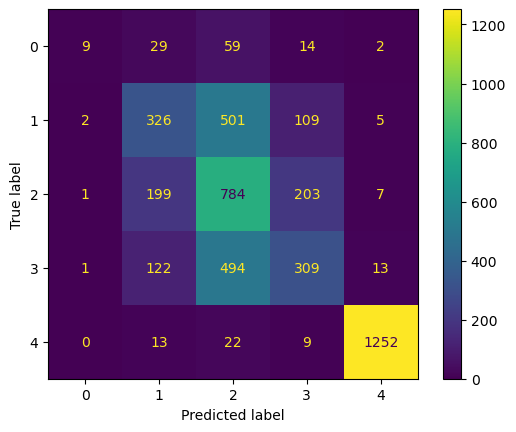

In [25]:
cm = confusion_matrix(y_test, baseline_results, labels=baseline_clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=baseline_clf.classes_)

disp.plot()
plt.show()

RandomForest has the best score among the chosen classification models, after preprocessing the data. This shall be our baseline model.

But the learning curve shows that obtaining more data will not help improve the performance of the model, as the validation score starts to stagnate around 5000 samples.

This means we need to focus more on the features and the encoding process, to help the model understand the current data better.

The model is also really struggling to differentiate between adoption speeds of 1,2 and 3, with the high number of FPs and FNs for the 3 classes.

## Hyper-parameter Tuning

Use random search grid as random forest has many different parameters covering a large range, resulting if high number of combinations.

In [17]:
from sklearn.model_selection import RandomizedSearchCV

In [18]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 7, 10]
min_samples_leaf = [1, 2, 4, 6]
bootstrap = [True, False]

In [19]:
random_grid = {'model__n_estimators': n_estimators,
               'model__max_features': max_features,
               'model__max_depth': max_depth,
               'model__min_samples_split': min_samples_split,
               'model__min_samples_leaf': min_samples_leaf,
               'model__bootstrap': bootstrap}

In [20]:
tuningModel_random = RandomizedSearchCV(estimator = pipeline, param_distributions = random_grid, 
                               n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)

search = tuningModel_random.fit(X, y)
print(search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'model__n_estimators': 600, 'model__min_samples_split': 7, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 89, 'model__bootstrap': False}


# Tuned Model

In [21]:
pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(transformers=[
        ('a1', MinMaxScaler(), ['Age','WordCount']),
        ('a2', OneHotEncoder(handle_unknown='ignore'), ['AgeBins','Pregnant']),
        ('a3', CountVectorizer(), 'Description'),], remainder='passthrough')),
    ('model', RandomForestClassifier(n_estimators=600,min_samples_split=7,min_samples_leaf=1,
                                    max_features='sqrt',max_depth=89,
                                    bootstrap=False))
])

In [22]:
scores = cross_val_score(pipeline,X,y,cv=kf)

0.5772402040480648


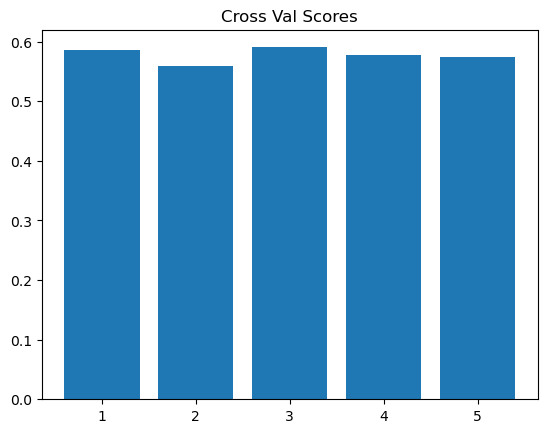

In [23]:
displayCrossValScores(scores)